## Just for doodling...

In [80]:
# Imports
import numpy as np
from scipy import optimize
from scipy import interpolate
from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt

# Constants
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16
sec_YEAR = 365*24*60*60

RAD_MAX_DISK = 1.361
ATMOS_FACTOR = 100

In [81]:
# Temperature functions
def tempKepDisk(r, r_inner, m_dot, m_star):
    term1 = 3*G*m_star*m_dot / (8 * np.pi * SIG_SB * (r**3))
    term2 = (1 - (r_inner/r)**(1/2))
    return (term1 * term2)**(1/4)

def tempFUOriDisk(r, r_inner, m_dot, m_star):
    # Doesn't read in as arrays for some reason,
    # doing this element-wise...
    res = np.zeros(len(r))
    for i in range(len(r)):
        if r[i] <= RAD_MAX_DISK*r_inner:
            res[i] = tempKepDisk(RAD_MAX_DISK*r_inner, r_inner, m_dot, m_star) \
                    + 1000*(1 - np.exp(3*(RAD_MAX_DISK*r_inner - r[i])/(RAD_MAX_DISK*r_inner)))
        else:
            res[i] = tempKepDisk(r[i], r_inner, m_dot, m_star)
    return res

def tempFUOriDiskMod(r, r_inner, m_dot, m_star):
    if r <= RAD_MAX_DISK*r_inner:
        res = tempKepDisk(RAD_MAX_DISK*r_inner, r_inner, m_dot, m_star) \
        + 1000*(1 - np.exp(3*(RAD_MAX_DISK*r_inner - r)/(RAD_MAX_DISK*r_inner)))
    else:
        res = tempKepDisk(r, r_inner, m_dot, m_star)
    return res
    
def tempFUOriDiskMin(r, r_inner, m_dot, m_star, val):
    return tempFUOriDiskMod(r, r_inner, m_dot, m_star) - val

# Annuli-generating functions
    
def find_nearest(array, value, side):
    array = np.asarray(array)
    min_vals = array-value
    max_vals = -min_vals
    if side == 'above':
        for i in range(len(min_vals)):
            if min_vals[i] < 0: min_vals[i] = np.inf
        idx = min_vals.argmin()
    if side == 'below':
        for i in range(len(min_vals)):
            if max_vals[i] < 0: max_vals[i] = np.inf
        idx = max_vals.argmin()
    return array[idx]

def getAvgOfPairs(arr):
    out_arr = np.zeros(len(arr)-1)
    for i in range(len(arr)-1):
        out_arr[i] = np.mean([arr[i], arr[i+1]])
    return out_arr

def makeOuterAnnuli(r_inner, r_outer, m_dot, m_star, r_start, r_binning):
    r_list = np.arange(r_start, r_outer+r_binning, r_binning)
    r_a = r_list[:-1]
    r_b = r_list[1:]
    r_avg = np.mean((r_a,r_b), axis=0)
    temps = tempFUOriDisk(r_avg, r_inner, m_dot, m_star)
    return temps, r_a, r_b

In [131]:
R_TEST = np.arange(R_SUN, 4*R_SUN, 0.001*R_SUN)

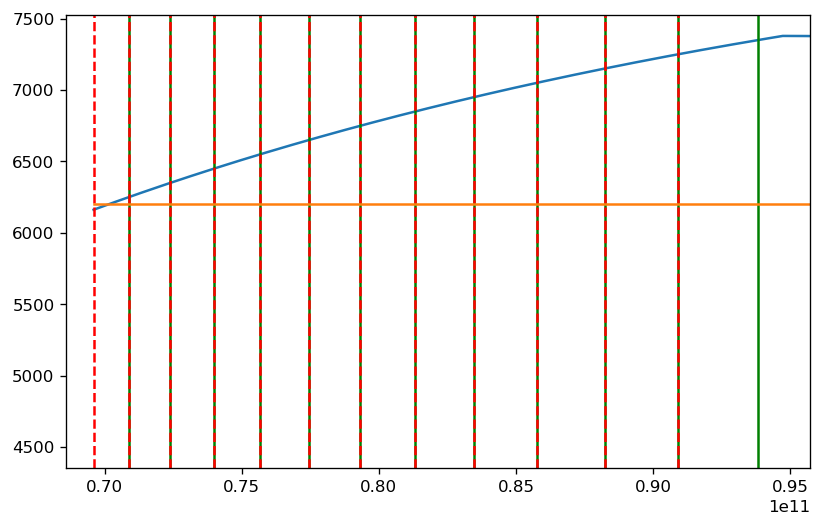

In [132]:
fig=plt.figure(figsize=(8, 5), dpi= 120)
plt.plot(R_TEST, tempFUOriDisk(R_TEST, R_SUN, 1e-6*M_SUN/sec_YEAR, M_SUN))
# plt.axvline(R_SUN, color='k')
for i in range(len(RAT)):
    plt.axvline(RAT[i], color='red', linestyle='--')
    plt.axvline(RBT[i], color='green', linestyle='-')
plt.xlim(R_SUN-1e9, RAD_MAX_DISK*R_SUN + 1e9)
plt.plot(R_TEST, 6200*np.ones(len(R_TEST)))
plt.show()

In [133]:
tempFUOriDiskMod(R_SUN, R_SUN, 1e-6*M_SUN/sec_YEAR, M_SUN), \
tempFUOriDiskMod(RAD_MAX_DISK*R_SUN, R_SUN, 1e-6*M_SUN/sec_YEAR, M_SUN)

(6162.314556560804, 7378.3913616634045)

In [167]:
def generateMasterList(r_inner, r_outer, m_dot, m_star, temp_max_poss, temp_min_poss, temp_binning, r_binning_outer):
    # Replace this at some point?
    RAD_MAX_DIST = RAD_MAX_DISK*r_inner
    inner_lists = generateMasterListInner(r_inner, RAD_MAX_DIST,\
                                          m_dot, m_star, temp_max_poss, temp_min_poss, temp_binning)
    outer_lists = generateMasterListOuter(r_inner, r_outer, RAD_MAX_DIST,\
                                          m_dot, m_star, temp_max_poss, temp_min_poss, temp_binning, r_binning_outer)
    
    final_lists = []
    for i in range(len(inner_lists)):
        final_lists[i] = np.concatenate((inner_lists[i], outer_lists[i]))
    return final_lists
        

In [139]:
def generateMasterListInner(r_inner, r_tmax, m_dot, m_star, temp_max_poss, temp_min_poss, temp_binning):
    # Max and min temperatures of defined disk
    max_temp = tempFUOriDiskMod(r_tmax, r_inner, m_dot, m_star)
    min_temp = tempFUOriDiskMod(r_inner, r_inner, m_dot, m_star)
    
    # Looking at all possible temperatures of given library
    temp_prelim = np.arange(temp_min_poss - 0.5*temp_binning, temp_max_poss + 1.5*temp_binning, temp_binning)
    min_nearest = find_nearest(temp_prelim, min_temp, 'above')
    max_nearest = find_nearest(temp_prelim, max_temp, 'below')
    
    # Making new list for annuli
    temp_spaced = np.arange(min_nearest, max_nearest + temp_binning, temp_binning)

    r_a = np.zeros(len(temp_spaced))
    for i in range(len(temp_spaced)):
        sol = optimize.root_scalar(tempFUOriDiskMin,args=(r_inner, m_dot, m_star, temp_spaced[i]),\
                                   bracket=[r_inner, r_tmax], method='brentq')
        r_a[i] = sol.root
    r_a = np.concatenate(([r_inner], r_a))
    r_b = np.concatenate((r_a[1:], [r_tmax]))
    
    # Average temperatures of annuli
    temp_radiating_prelim = getAvgOfPairs(temp_spaced)
    temp_radiating = np.concatenate(([np.min(temp_radiating_prelim) - temp_binning],\
                                     temp_radiating_prelim,\
                                     [np.max(temp_radiating_prelim) + temp_binning]))
    
    # Adding temperatures below final stellar atmosphere
    # EXCLUDING FINAL VALUES since they're accounted for in the outer annuli
    temp_radiating_curr = temp_radiating[:-1]
    r_a_curr = r_a[:-1]
    r_b_curr = r_b[:-1]

    return temp_radiating_curr, r_a_curr, r_b_curr

In [138]:
TT, RAT, RBT = generateMasterListInner(R_SUN, RAD_MAX_DISK*R_SUN, 1e-6*M_SUN/sec_YEAR, M_SUN, 10000, 2000, 100)

[6250. 6350. 6450. 6550. 6650. 6750. 6850. 6950. 7050. 7150. 7250. 7350.]
[6.96000000e+10 7.08747528e+10 7.23942594e+10 7.39906030e+10
 7.56719705e+10 7.74479307e+10 7.93297651e+10 8.13309018e+10
 8.34674975e+10 8.57592313e+10 8.82304084e+10 9.09115355e+10
 9.38416271e+10]
[7.08747528e+10 7.23942594e+10 7.39906030e+10 7.56719705e+10
 7.74479307e+10 7.93297651e+10 8.13309018e+10 8.34674975e+10
 8.57592313e+10 8.82304084e+10 9.09115355e+10 9.38416271e+10
 9.47256000e+10]


In [161]:
def generateMasterListOuter(r_inner, r_outer, r_tmax, m_dot, m_star, temp_max_poss, temp_min_poss, temp_binning, r_binning_outer):
    # Max and min temperatures of defined disk
    max_temp = tempFUOriDiskMod(r_tmax, r_inner, m_dot, m_star)
    min_temp = tempFUOriDiskMod(r_outer, r_inner, m_dot, m_star)
    
    # Looking at all possible temperatures of given library
    temp_prelim = np.arange(temp_min_poss - 0.5*temp_binning, temp_max_poss + 1.5*temp_binning, temp_binning)
    min_nearest = find_nearest(temp_prelim, min_temp, 'above')
    max_nearest = find_nearest(temp_prelim, max_temp, 'below')
    
    # Making new list for annuli
    temp_spaced = np.arange(min_nearest, max_nearest + temp_binning, temp_binning)
    print(temp_spaced)
    r_a = np.zeros(len(temp_spaced)+1)
    for i in range(len(temp_spaced)):
        sol = optimize.root_scalar(tempFUOriDiskMin,args=(r_inner, m_dot, m_star, temp_spaced[i]),\
                                   bracket=[r_tmax, r_outer], method='brentq')
        r_a[i] = sol.root
    r_a[-1] = r_tmax
    r_b = np.concatenate(([r_outer], r_a))[:-1]
    
    # Average temperatures of annuli
    temp_radiating_prelim = getAvgOfPairs(temp_spaced)
    temp_radiating = np.concatenate(([np.min(temp_radiating_prelim) - temp_binning],\
                                     temp_radiating_prelim,\
                                     [np.max(temp_radiating_prelim) + temp_binning]))
    
    # Adding temperatures below final stellar atmosphere
    # EXCLUDING FINAL VALUES since they're accounted for in the outer annuli
    temp_radiating_curr = temp_radiating[::-1][:-1]
    r_a_curr = r_a[::-1][:-1]
    r_b_curr = r_b[::-1][:-1]
    r_start = r_b_curr[-1]
    temp_radiating_outer, r_a_outer, r_b_outer = makeOuterAnnuli(r_inner, r_outer,\
                                                                 m_dot, m_star, r_start, r_binning_outer)
    
    temp_radiating_final = np.concatenate((temp_radiating_curr, temp_radiating_outer))
    r_a_final = np.concatenate((r_a_curr, r_a_outer))
    r_b_final = np.concatenate((r_b_curr, r_b_outer))
    
    return temp_radiating_final, r_a_final, r_b_final

In [162]:
TT2, RAT2, RBT2 = generateMasterListOuter(R_SUN, 20*R_SUN, \
                                          RAD_MAX_DISK*R_SUN, 1e-6*M_SUN/sec_YEAR, M_SUN, 10000, 2000, 100, R_SUN)

[1950. 2050. 2150. 2250. 2350. 2450. 2550. 2650. 2750. 2850. 2950. 3050.
 3150. 3250. 3350. 3450. 3550. 3650. 3750. 3850. 3950. 4050. 4150. 4250.
 4350. 4450. 4550. 4650. 4750. 4850. 4950. 5050. 5150. 5250. 5350. 5450.
 5550. 5650. 5750. 5850. 5950. 6050. 6150. 6250. 6350. 6450. 6550. 6650.
 6750. 6850. 6950. 7050. 7150. 7250. 7350.]


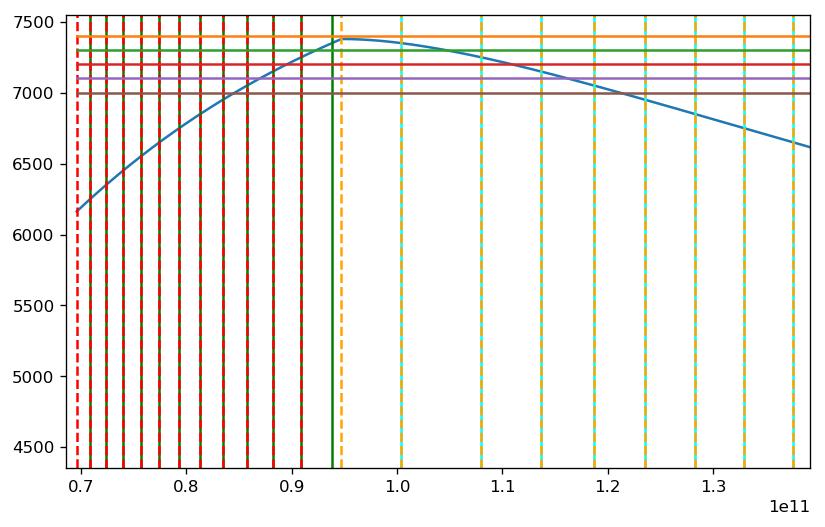

In [163]:
fig=plt.figure(figsize=(8, 5), dpi= 120)
plt.plot(R_TEST, tempFUOriDisk(R_TEST, R_SUN, 1e-6*M_SUN/sec_YEAR, M_SUN))
# plt.axvline(R_SUN, color='k')
for i in range(len(RAT)):
    plt.axvline(RAT[i], color='red', linestyle='--')
    plt.axvline(RBT[i], color='green', linestyle='-')

for i in range(len(RAT2)):
    plt.axvline(RAT2[i], color='orange', linestyle='--')
    plt.axvline(RBT2[i], color='cyan', linestyle='-')

for i in range(5):
    plt.plot(R_TEST, TT2[i]*np.ones(len(R_TEST)))

plt.xlim(R_SUN-1e9, 2*R_SUN)
plt.show()